In [1]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
from idqn.utils.confidence_interval import confidence_interval

experiment_name = "test/Breakout"
list_bellman_iterations_scope = [10]
seeds = [11]

p = json.load(open(f"figures/{experiment_name.split('/')[0]}/parameters.json"))

n_seeds = len(seeds)
ticks_freq = 10

### Extract data

In [2]:
idqn_j = np.zeros((len(list_bellman_iterations_scope), n_seeds, p["n_epochs"] + 1)) * np.nan

for idx, bellman_iterations_scope in enumerate(list_bellman_iterations_scope):
    for idx_seed, seed in enumerate(seeds):
        idqn_j[idx, idx_seed] = np.load(f"figures/{experiment_name}/iDQN/{bellman_iterations_scope}_J_{seed}.npy")

### Performances

In [4]:
idqn_j_mean = idqn_j.mean(axis=1)
idqn_j_std = idqn_j.std(axis=1)
idqn_j_confidence_interval = np.zeros((len(list_bellman_iterations_scope), 2, p["n_epochs"] + 1))

for idx in range(len(list_bellman_iterations_scope)):
    idqn_j_confidence_interval[idx] = confidence_interval(idqn_j_mean[idx], idqn_j_std[idx], n_seeds)

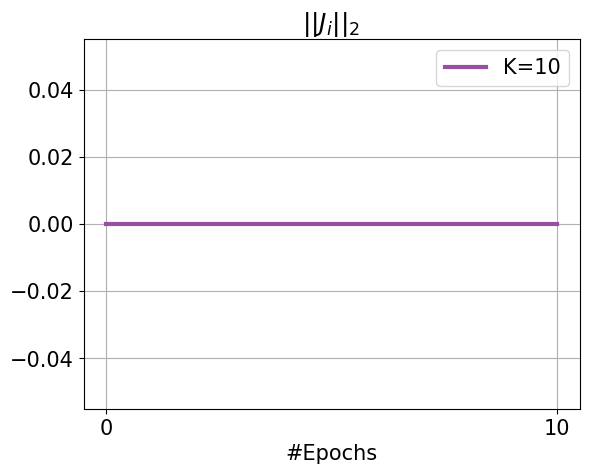

In [5]:
import matplotlib.pyplot as plt 
from experiments import colors

plt.rc("font", size=15)
plt.rc("lines", linewidth=3)

iterations = range(p["n_epochs"] + 1)

for idx, bellman_iterations_scope in enumerate(list_bellman_iterations_scope):
    plt.plot(iterations, idqn_j_mean[idx], label=f"K={bellman_iterations_scope}", color=colors[f"{idx}"], zorder=2)
    plt.fill_between(iterations, idqn_j_confidence_interval[idx, 0], idqn_j_confidence_interval[idx, 1], color=colors[f"{idx}"], alpha=0.3, zorder=2)

plt.xticks(range(0, p["n_epochs"] + 1, ticks_freq))
plt.xlabel("#Epochs")
plt.title(r"$|| J_i ||_2$")
plt.legend().set_zorder(3)
plt.grid(zorder=0)
_ = plt.savefig(f"figures/{experiment_name}/J.pdf", bbox_inches='tight')